In [1]:
import csv
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
torch.manual_seed(42)
d_opts = [('cuda', torch.cuda.is_available()), ('mps', torch.backends.mps.is_available()), ('cpu', True)]
device = next(device for device, available in d_opts if available)
print(f'using device: {device}')

using device: cuda


In [3]:
!wget https://huggingface.co/datasets/lukasnxyz/nasa-mars-images/resolve/main/normalized_nasa_mars_images.csv

--2025-02-18 20:52:02--  https://huggingface.co/datasets/lukasnxyz/nasa-mars-images/resolve/main/normalized_nasa_mars_images.csv
Resolving huggingface.co (huggingface.co)... 13.35.202.121, 13.35.202.40, 13.35.202.97, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.121|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/6b/1f/6b1ff55720b817af48e0e04b694206750753adf284717e82f04b7512bc7078e4/be8f5b12e6e2262a6b47437bdaeb46db37074a4a018273ae6daabf6ca99f93c9?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27normalized_nasa_mars_images.csv%3B+filename%3D%22normalized_nasa_mars_images.csv%22%3B&response-content-type=text%2Fcsv&Expires=1739915522&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczOTkxNTUyMn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzZiLzFmLzZiMWZmNTU3MjBiODE3YWY0OGUwZTA0YjY5NDIwNjc1MDc1M2FkZjI4NDcxN2U4MmYwNGI3NTEyYmM3MDc4ZTQvYmU4ZjViMTJ

In [4]:
data_csv = 'normalized_nasa_mars_images.csv'
with open(data_csv, mode='r') as f:
    reader = csv.reader(f)
    data = np.array([[np.float32(item) for item in row] for row in tqdm(reader, desc='loading csv data')])

# need to at random choose roughly 2100 of the 52,722 images labled 0 (other)
# to fix the skewed distribution of samples
n = int(0.65*len(data))
data_tr, data_val = data[:n], data[n:]

Xtr, Ytr = torch.from_numpy(data_tr[:, 1:]).to(device), torch.from_numpy(data_tr[:, 0]).to(torch.int64).to(device)
Xtr = Xtr.view(n, 50, 50)

Xval, Yval = torch.from_numpy(data_val[:, 1:]).to(device), torch.from_numpy(data_val[:, 0]).to(torch.int64).to(device)
Xval = Xval.view(len(data)-n, 50, 50)

Xtr = Xtr.unsqueeze(1)
Xval = Xval.unsqueeze(1)

loading csv data: 14225it [00:29, 475.70it/s]


In [6]:
# data information
print(Xtr.shape)

torch.Size([9246, 1, 50, 50])


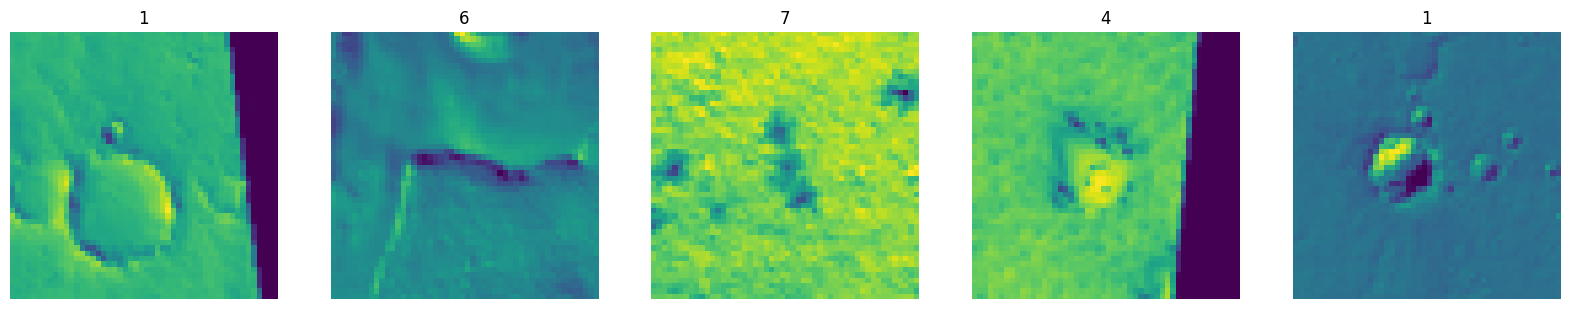

In [7]:
idxs = np.random.randint(Xtr.shape[0], size=5)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(idxs):
    ax = axes[i]
    image = Xtr[idx].squeeze(0).cpu().numpy()
    label = Ytr[idx].squeeze(0).cpu().numpy()
    im = ax.imshow(image)
    ax.set_title(label)
    ax.axis('off')
plt.show();

{0: 2000, 1: 5024, 2: 766, 3: 1575, 4: 1654, 5: 476, 6: 1834, 7: 896}


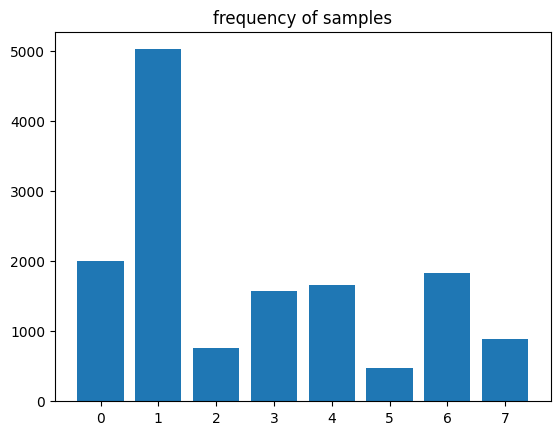

In [8]:
cc_list = torch.cat((Ytr, Yval)).tolist()
cc_dict = {}
for i in range(8):
    if i not in cc_dict:
        cc_dict[i] = 0
for i in cc_list:
    cc_dict[i] += 1

print(cc_dict)
plt.bar(cc_dict.keys(), cc_dict.values())
plt.title('frequency of samples')
plt.show();

In [9]:
class CNN_MODEL(nn.Module):
    def __init__(self, in_size: int, n_classes: int, dropout: int, conv_kernel_size=(2,2)):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(1, 50, kernel_size=conv_kernel_size, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout(dropout)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(50, 50, kernel_size=conv_kernel_size, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout(dropout)
        )

        # calc flattened size dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, in_size, in_size) # batch_size, 1, 1 channel
            flattened_size = torch.flatten(self.conv_block_2(self.conv_block_1(dummy_input)), start_dim=1).shape[1]

        self.dense_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, n_classes)
        )

    def forward(self, X):
        X = self.conv_block_1(X)
        X = self.conv_block_2(X)
        X = self.dense_block(X)
        return X

In [10]:
# experiment tracking (should implement)
# - keep track of hyperparameters and the stats that they provide
# tr+val sizes, learning rate, dropout, epochs

# model hyperparameters
input_size = 50
num_classes = 8
dropout = 0.3
conv_kernel_size = (4,4)

# training hyperparameters
lr = 1e-4
batch_size = 32
epochs = 2000
epoch_eval = 200

In [11]:
model = CNN_MODEL(in_size=input_size, n_classes=num_classes,
                  dropout=dropout, conv_kernel_size=conv_kernel_size).to(device)
print(f'num of params: {sum([p.numel() for p in model.parameters()])}')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
losses = []

num of params: 6245324


In [12]:
st = time.time()
for epoch in range(epochs):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model(Xb)
    loss = loss_fn(logits, Yb)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    lr = 1e-8 if epoch >= 600 else 1e-4

    if epoch % epoch_eval == 0:
        print(f'epoch: {epoch}, time: {time.time()-st:.4f}s, tr loss: {loss.item()}')

et = time.time()
print(f'training took: {et-st:.1f}s')

epoch: 0, time: 0.2363s, tr loss: 2.0849459171295166
epoch: 200, time: 1.4765s, tr loss: 1.7659224271774292
epoch: 400, time: 2.6687s, tr loss: 1.0998581647872925
epoch: 600, time: 3.8599s, tr loss: 0.7697625160217285
epoch: 800, time: 5.0515s, tr loss: 0.6864801645278931
epoch: 1000, time: 6.2540s, tr loss: 1.2462873458862305
epoch: 1200, time: 7.4492s, tr loss: 1.004944920539856
epoch: 1400, time: 9.0571s, tr loss: 0.6442996859550476
epoch: 1600, time: 10.6342s, tr loss: 1.148017406463623
epoch: 1800, time: 11.8588s, tr loss: 0.9270145893096924
training took: 13.0s


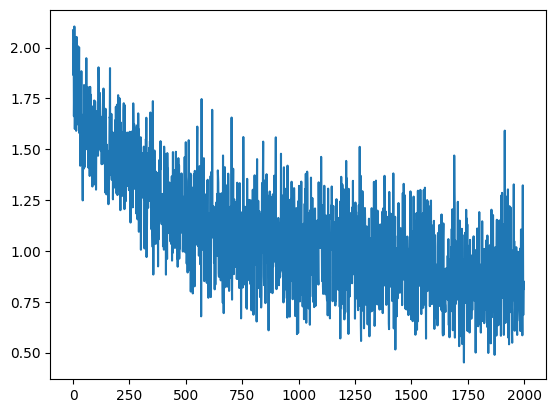

In [13]:
# plot train and val loss
plt.plot(losses);

In [14]:
@torch.no_grad()
def split_loss(split: str):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
    }[split]
    logits = model(x.float())
    loss = loss_fn(logits, y)
    print(split, loss.item())

with torch.inference_mode():
    split_loss('train')
    split_loss('val')

train 0.8356234431266785
val 5.026578903198242


In [15]:
model.eval()
with torch.inference_mode():
    def accuracy_fn(y_true, y_pred):
        correct = torch.eq(y_true, y_pred).sum().item()
        acc = (correct / len(y_pred)) * 100
        return acc
    logits = model(Xval)
    acc = accuracy_fn(y_pred=logits.argmax(dim=1),
                     y_true=Yval)
    print(f'Accuracy: {acc:.2f}%')

Accuracy: 40.87%
